In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import decomposition

## Basic functions

In [2]:
def center_and_reduce(xmat, inplace=True):
    """
    Center and reduce data
    
    Params:
        xmat (numpy.ndarray) : the data matrix
        inplace (bool) : should the operation be performed inplace ?
        
    Returns:
        None. If inplace = True
        numpy.ndarray. If inplace= False
    """
    d = xmat.shape[0]
    n = xmat.shape[1]
    xmean = np.mean(xmat, axis=1)
    xvar = np.var(xmat, axis=1)
    meanmat = np.repeat(xmean.reshape((d,1)), n, axis=1)
    varmat = np.repeat(xvar.reshape((d,1)), n, axis=1)
    if inplace :
        xmat = (1 / varmat) * (xmat - meanmat)
    else:
        return (1 / varmat) * (xmat - meanmat)

In [3]:
def data_from_label(xmat, y, label):
    """
    Extract columns in xmat that have the specified label
    
    Params:
        xmats (numpy.ndarray) :  the data matrix
        y (numpy.ndarray) : the corresponding labels vector
        
    Returns:
        numpy.ndarray : the submatrix of xmat corresponding to the labels
    """
    indices = np.argwhere(y == label)
    return xmat[:, indices[:, 0]]

## Class wrapper for loss functions
We create here an almost empty class model for losses functions (basically a dictionnary of functions). The idea is to be modular in the loss function

In [4]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
        self.pegasos_batch_update = None
    
    def set_primal(self, func):
        """
        Params:
            func (func) : function to set primal class attribute to 
        """
        self.primal = func
    
    def set_dual(self, func):
        """
        Params:
            func (func) : function to set dual class attribute to 
        """
        self.dual = func
    
    def set_sdca_update(self, func):       
        """
        Params:
            func (func) : function to set sdca_update class attribute to 
        """
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        """
        Params:
            func (func) : function to set sgd_update class attribute to 
        """
        self.sgd_update = func
    
    def set_pegasos_batch_update(self, func):
        """
        Params:
            func (func) : function to set pegasos_batch_update class attribute to 
        """
        self.pegasos_batch_update = func

## Definition of Hinge loss using the LossFunc class wrapper
We define the hinge loss using the class framework defined above

In [5]:
def vector_hinge_loss(a, y):
    """
    Vectorized hinge loss
    
    Params:
        a (numpy.ndarray) : point to evaluate the loss at
        y (numpy.ndarray) : the labels to parametrize 
    
    Returns:
        numpy.ndarray : the vector of hinge losses
    """
    return np.maximum(0, 1 - y * a)


def vector_hinge_dual(alpha, y):
    """
    Vectorized dual version of hing loss
    
    Params:
        alpha (numpy.ndarray) : point to evaluate the dual func at
        y (numpy.ndarray) : the labels to parametrize
        
    Returns:
        numpy.ndarray : the vector of dual of hinge loss
    """
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod


def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    """
    The variation of alpha's i-th coordinate to decrease the dual of the hinge loss
    
    Params :
        w (numpy.ndarray) : primal parameter vector from previous iteration
        xi (numpy.ndarray) : i-th column of the data matrix
        yi (int) : the label for xi
        alphai (float) : current value of coordinate i of alpha
        lamb (float) : the regularization parameter
    
    Returns : 
        float : the optimal delta in alphai to decrease dual
    """
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai * yi
    return yi * max(0, min(1, q)) - alphai


# Fill class wrapper of LossFunc for hinge loss
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating $w(\alpha)$ to $\alpha$)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [6]:
def xmatT_dot_w(xmat, w):
    """
    Matrix product between xmat transpose and w
    """
    return np.dot(xmat.T, w)

In [7]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    """
    Value of the primal objective
    
    Params : 
        w (numpy.ndarray) : the primal vector
        xmat (numpy.ndarray) : the data matrix
        y (numpy.ndarray) : the label vector
        lamb (float) : regularization parameter
        lossfunc (LossFunc) : the loss function in a LossFunc class wrapper
    
    Returns : 
        float : value of the primal objective
    """
    a = xmatT_dot_w(xmat, w)
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [8]:
def alpha_to_w(alpha, xmat, lamb):
    """
    Function linking the primal and the dual variables  
    
    Params : 
        alpha (numpy.ndarray) : the dual variable
        xmat (numpy.ndarray) : the data matrix
        lamb (float) : regularization parameter
    
    Returns:
        numpy.ndarray : the correponding primal variable
    """
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)

In [9]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    """
    Value of the dual objective
    
    Params : 
        alpha (numpy.ndarray) : the dual vector
        xmat (numpy.ndarray) : the data matrix
        y (numpy.ndarray) : the label vector
        lamb (float) : regularization parameter
        lossfunc (LossFunc) : the loss function in a LossFunc class wrapper
    
    Returns : 
        float : value of the dual objective
    """
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual - reg

In [10]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    """
    Computes the duality gap
    
    Params : 
        alpha (numpy.ndarray) : the dual variable
        xmat (numpy.ndarray) : the data matrix
        y (numpy.ndarray) : the label vector
        lamb (float) : regularization parameter
        lossfunc (LossFunc) : the loss function in a LossFunc class 
    
    Returns:
        float : the value of the dual gap
    """
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Let us remark first of all that we must take $\alpha_t$ to be such that $\alpha_t y_t \in [0, 1]$ since if this is not the case, $- \phi_t^{\star}(-\alpha_t) = - \infty$. 

Now supposing that $\alpha_t y_t \in [0, 1]$, developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative to 0 w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t}{\lambda t}||x_t||^2  = 0$$


This gives us an optimal $\alpha_t^{\star}$ which is given by : 
$$ \alpha_t^{\star} = \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

Let us now ensure that we threshold this value to make sure that $\alpha_t y_t \in [0, 1]$: The optimal value is thus $\tilde{\alpha_t}$:
\begin{eqnarray*}
    \tilde{\alpha_t} &=& \alpha_t^{\star} ~if~\alpha_t^{\star} y_t \in [0, 1] \\
    \tilde{\alpha_t} &=& \min(0, y_t)~if~\alpha_t^{\star} < \min(0, y_t)\\
    \tilde{\alpha_t} &=& \max(0, y_t)~if~\alpha_t^{\star} > \max(0, y_t)\\
\end{eqnarray*}

In [11]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    """
    Compute optimal t-th coordinate for alpha of SGD initialization

    Params:
        w (numpy.ndarray) : value of primal variable in t-1
        xt (numpy.ndarray) : t-th column of data matrix
        yt (numpy.ndarray) : the label of xt
        lamb (numpy.ndarray) : regularization parameter
    
    Returns:
        float : optimal SGD initialization for t-th coordinate of alpha
    """
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    val = ((lamb * t) / xsqrnorm) * (yt - wdotx)
    return min(max(val, min(0, yt)), max(0, yt))


# Incorporate it in the LossFunc wrapper for hinge loss
hinge.set_sgd_update(hinge_sgd_update)

In [12]:
def modified_sgd(alpha, w, xmat, y, lamb, lossfunc=hinge):
    """
    Perform modified SGD initialization when alpha=0
    
    Params:
        alpha (numpy.ndarray) : initial alpha, must be 0
        
    """
    n = xmat.shape[1]
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t+1)
        w *= float(t) / float(t + 1)
        w += (1 / (lamb * float(t + 1))) * alpha[t] * xmat[:, t]   
        # w = alpha_to_w(alpha[t], xmat[:, :t+1], lamb)

## Deduction of a classifier

In [13]:
def classify(wstar, xmat_test):
    """
    Classify using the linear svm defined by its parameters vector wstar
    
    Params:
        wstar (numpy.ndarray) : the parameters vector for the SVM
        xmat_test (numpy.ndarray) : the test set
        
    Returns:
        numpy.ndarray : the vector of predicted labels
    """
    prod = np.dot(xmat_test.T, wstar)
    prod[prod >= 0] = 1
    prod[prod < 0] = -1
    return prod

In [14]:
def get_score(w, xtest, ytest):
    """
    Classify using the classify function above and compute the error rate of the predicted labels vs the real ones
    
    Params:
        wstar (numpy.ndarray) : the parameters vector for the SVM
        xtest (numpy.ndarray) : the test set
        ytest (numpy.ndarray) : the labels correponding to the test set
    
    Returns:
        float : the error rate
    """
    ypred = classify(w, xtest)
    score = metrics.zero_one_loss(ypred, ytest)
    return score

## SDCA Perm

In [15]:
def sdca_perm_updates(w, alpha, xmat, y, lamb, lossfunc=hinge):
    """
    Perform one epoch of SDCA perm
    
    Params:
        w (numpy.ndarray) : the primal variables vector (will be modified INPLACE)
        alpha (numpy.ndarray) : the dual variables vector (will be modified INPLACE)
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
    
    Returns:
        NoneType : w and alpha are modified INPLACE
    """
    n = xmat.shape[1]
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    for j in range(0, n):
        i = inds[j]
        delta = lossfunc.sdca_update(w, xmat[:, i], y[i], alpha[i], lamb)
        alpha[i] += delta
        if (alpha[i] * y[i] < 0) or (alpha[i] * y[i] > 1):
            print (alpha[i])
        w += (1.0 / float(lamb * n)) * delta * xmat[:, i]

In [16]:
def init_tracking(alpha0, w, xmat, y, lamb, lossfunc, xtest):
    """
    Initialization of the different tracking list for SDCA
    
    Params:
        alpha0 (numpy.ndarray) : the initial dual variables vector
        w (numpy.ndarray) : the initial primal variables vector
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
        xtest (numpy.ndarray) : the test set
        
    Returns:
        tuple : a tuple of one item list : loss_track, gaps_track, perfs, scores_test (optionnal) which respectively 
        record : the losses on the training set, the duality gaps, the CPU time for each epochs 
        and (optionnal) the error rate on test set
    
    """
    # Keep track of the losses
    loss_track = list()
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    
    # Keep track of the duality gaps
    gap = duality_gap(alpha0, xmat, y, lamb, lossfunc)
    gaps_track = [gap]
    
    # Initialization of CPU perfs counter
    perfs = [0]
    
    # Keep track of the score on the test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test = [score]
        return loss_track, gaps_track, perfs, score_test

    return loss_track, gaps_track, perfs

In [17]:
def sgd_epoch(alpha, 
              w,
              xmat, 
              y, 
              lamb, 
              lossfunc, 
              xtest, 
              ytest,
              loss_track, 
              gaps_track, 
              perfs, 
              score_test):
    """
    Perform first SGD epoch using the modified_sdg function and fills the tracking lists
    
    Params:
        alpha (numpy.ndarray) : the dual variables vector
        w (numpy.ndarray) : the primal variables vector
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
        xtest (numpy.ndarray) : the test set
        ytest (numpy.ndarray) : the labels for the test set
        loss_track (list) : the list recording the losses
        gaps_track (list) : the list recording the duality gaps
        perfs (list) : the list recording the CPU performances
        score_test (list) : the list recording the error rate on the test set
    
    Returns :
        NoneType : Updates of alpha, w, loss_track, gaps_track, perfs and score_test are performed INPLACE
    """
    start = time.clock()
    modified_sgd(alpha, w, xmat, y, lamb)
    end = time.clock()
    # Track CPU perfs
    perfs.append(end - start)
    # Track losses
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    # Track duality gap
    gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    gaps_track.append(gap)
    # Track 0-1 score on test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test.append(score)

In [18]:
def sdca_epoch(alpha, 
               w,
               xmat, 
               y, 
               lamb, 
               lossfunc, 
               xtest, 
               ytest,
               loss_track, 
               gaps_track, 
               perfs, 
               score_test):
    """
    Perform an SDCA epoch using the sdca_perm_updates function and fills the tracking lists
    
    Params:
        alpha (numpy.ndarray) : the dual variables vector
        w (numpy.ndarray) : the primal variables vector
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
        xtest (numpy.ndarray) : the test set
        ytest (numpy.ndarray) : the labels for the test set
        loss_track (list) : the list recording the losses
        gaps_track (list) : the list recording the duality gaps
        perfs (list) : the list recording the CPU performances
        score_test (list) : the list recording the error rate on the test set
    
    Returns :
        NoneType : Updates of alpha, w, loss_track, gaps_track, perfs and score_test are performed INPLACE
    """
    start = time.clock()
    sdca_perm_updates(w, alpha, xmat, y, lamb, lossfunc)
    end = time.clock()
    # Track CPU perfs
    perfs.append(end - start)
    # Track losses
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    # Track duality gap
    gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    gaps_track.append(gap)
    # Track 0-1 score on test set
    if isinstance(xtest, np.ndarray):
        score = get_score(w, xtest, ytest)
        score_test.append(score)


In [19]:
def sdca_perm(alpha0, 
              xmat, 
              y, 
              lamb, 
              nepochs, 
              epsilon, 
              lossfunc=hinge, 
              sgd_first=True, 
              xtest=None, 
              ytest=None):
    
    """
    Iterate SDCA epochs and record losses, performances, duality gaps and (optionnal) scores on test set
    
    Params:
        alpha0 (numpy.ndarray) : the initial dual variables vector
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        nepochs (int) : the maximal number of epochs to perform
        epsilon (float) : the duality gap stopping threshold
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
        sgd_first (bool) : should first epoch be performed as modified SGD ?
        xtest (numpy.ndarray) : the test set
        ytest (numpy.ndarray) : the labels for the test set
        
    Returns:
        tuple : w, alpha, loss_track, perfs, gaps_track, score_test
            respectively : the optimized primal and dual vectors, the list tracking losses, 
            the list tracking performances, the list tracking duality gaps, 
            (optionnal) the list tracking the error rate on the test set.
    """
    
    # Find out dataset size
    n = xmat.shape[1]
    
    # Work on a copy of alpha0
    alpha = alpha0.copy()
    
    # Initialize w from alpha
    w = alpha_to_w(alpha0, xmat, lamb)
    
    # Initialization of tracking in the case we want to track score on test set
    if isinstance(xtest, np.ndarray):
        loss_track, gaps_track, perfs, score_test = init_tracking(alpha0, w, xmat, y, lamb, 
                                                                  lossfunc, xtest)
    
    # Initialization of tracking in the case we do not want to track score on test set
    else:
        loss_track, gaps_track, perfs = init_tracking(alpha0, w, xmat, y, lamb, 
                                                      lossfunc, xtest)
        score_test=None
        
    # Initialization of epochs counter
    k = 0
    gap = gaps_track[k]
    
    # Perform SGD as first epoch if sgd_first is set to True
    if sgd_first:
        sgd_epoch(alpha, w, xmat, y, lamb, lossfunc, xtest, ytest,
                  loss_track, gaps_track, perfs, score_test)
        k += 1
        gap = gaps_track[k]
        
    # Perform the SDCA epochs
    while (gap > epsilon) and (k < nepochs):
        sdca_epoch(alpha, w, xmat, y, lamb, lossfunc, xtest, ytest, 
                   loss_track, gaps_track, perfs, score_test)
        k += 1
        gap = gaps_track[k]
        
    # Return the 
            
    if isinstance(xtest, np.ndarray):
        return w, alpha, loss_track, perfs, gaps_track, score_test
    else:
        return w, alpha, loss_track, perfs, gaps_track

## Pegasos algorithm (=stochastic subgradient descent)

In [20]:
def hinge_loss_update(w, xmat, y, eta, lamb, batch_indexes):
    """ 
    Updates for a given minibatch for Pegasos corresponding to the hinge loss 
    
    Params:
        w (numpy.ndarray) : the primal variables vector (will be modified INPLACE)
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        eta (float) : the learning rate
        lamb (float) : the regularization parameter
        batch_indexes (numpy.ndarray) : the minibatch indexes from which to compute the updates
    
    Returns:
        NoneType : w is modified INPLACE
    """
    k = batch_indexes.shape[0]
    restricted_xmat = xmat[:, batch_indexes]
    restricted_y = y[batch_indexes]
    dot = xmatT_dot_w(restricted_xmat, w)
    indic = (restricted_y * dot < 1).astype(np.int64)
    summed_vec = np.dot(restricted_xmat, restricted_y * indic)
    w *= (1 - eta * lamb)
    w += (float(eta) / float(k)) * summed_vec


# Add it to the LossFunc wrapper for the hinge loss
hinge.set_pegasos_batch_update(hinge_loss_update)

In [21]:
def pegasos_algorithm(w,
                      xmat,
                      y,
                      lamb,
                      k,
                      nepochs,
                      lossfunc=hinge,
                      xtest=None,
                      ytest=None):
    """
    Iterate Pegasos epochs and record losses, performances and (optionnal) scores on test set
    
    Params:
        w (numpy.ndarray) : the initial primal variables vector (will be modifier INPLACE)
        xmat (numpy.ndarray) : the training data set
        y (numpy.ndarray) : the labels corresponding to xmat
        lamb (float) : the regularization parameter
        k (int) : minibatch size
        nepochs (int) : the maximal number of epochs to perform
        lossfunc (LossFunc) : the loss function using the class wrapper LossFunc
        xtest (numpy.ndarray) : the test set
        ytest (numpy.ndarray) : the labels for the test set
        
    Returns:
        tuple : loss_track, perfs, (optionnal) score_test
            respectively : the list tracking losses, 
            the list tracking performances,
            (optionnal) the list tracking the error rate on the test set.
    """
    
    n = xmat.shape[1]
    loss_track = list()
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    t = 1
    perfs = [0]
    if isinstance(xtest, np.ndarray):
        score_test = []
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    for epoch in range(0, nepochs):
        start = time.clock()
        indexes = np.array(range(0, n))
        np.random.shuffle(indexes)
        for i in range(0, n // k):
            eta = 1.0 / (float(lamb * t))
            lossfunc.pegasos_batch_update(
                w, xmat, y, eta, lamb, indexes[i * k: (i + 1) * k])
            t += 1
        end = time.clock()
        perfs.append(end - start)
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        if isinstance(xtest, np.ndarray):
            score = get_score(w, xtest, ytest)
            score_test.append(score)
    if isinstance(xtest, np.ndarray):
        return loss_track, perfs, score_test
    else:
        return loss_track, perfs


## Monte Carlo Comparison functions
Since the two algorithms are stochastic to some extent we average the different performance results across several executions.

In [59]:
def mc_comparisons_sdca(xtrain,
                        ytrain,
                        lamb,
                        nepochs,
                        xtest,
                        ytest,
                        nmc,
                        epsilon,
                        sgd_first=True):
    """
    Runs several times the sdca_perm function and averages the tracking lists
    
    Params:
        xtrain: (numpy.ndarray) : the training data set
        ytrain: (numpy.ndarray) : the labels vector for the training data set
        lamb: (float) : the regularization parameter
        nepochs: (int) : the number of epochs)
        xtest: (numpy.ndarray) : the test set
        ytest: numpy.ndarray) : the labels for the test set
        nmc: (int) : number of Monte Carlo iteration
        sgd_first: (bool) : Should first epoch be performed as modified-SGD instead of SDCA ?
        
    Returns:
        tuple : the tracking lists averaged over the nmc iterations : 
            loss_track, perfs, gaps_track, score_test
    """
    n = xtrain.shape[1]
    alpha0 = np.zeros((n,))
    w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(
        alpha0, xtrain, ytrain, lamb, nepochs, epsilon, sgd_first=sgd_first, xtest=xtest, ytest=ytest)
    losses_sdca = np.array(losses_sdca)
    perfs_sdca = np.array(perfs_sdca)
    gaps_sdca = np.array(gaps_sdca)
    scores_sdca = np.array(scores_sdca)
    for i in range(1, nmc):
        w, alpha, losses, perfs, gaps, scores = sdca_perm(alpha0,
                                                          xtrain,
                                                          ytrain,
                                                          lamb,
                                                          nepochs,
                                                          epsilon,
                                                          sgd_first=sgd_first,
                                                          xtest=xtest,
                                                          ytest=ytest)
        losses_sdca += np.array(losses)
        perfs_sdca += np.array(perfs)
        gaps_sdca += np.array(gaps)
        scores_sdca += np.array(scores)
        print(i)
    losses_sdca *= (1.0 / float(nmc))
    perfs_sdca *= (1.0 / float(nmc))
    gaps_sdca *= (1.0 / float(nmc))
    scores_sdca *= (1.0 / float(nmc))
    return losses_sdca, perfs_sdca, gaps_sdca, scores_sdca

In [23]:
def mc_comparisons_pegasos(xtrain,
                           ytrain,
                           lamb,
                           minibatch,
                           nepochs,
                           xtest,
                           ytest,
                           nmc):
    """
    Runs several times the pegasos_algorithm function and averages the tracking lists
    
    Params:
        xtrain: (numpy.ndarray) : the training data set
        ytrain: (numpy.ndarray) : the labels vector for the training data set
        lamb: (float) : the regularization parameter
        minibatch (int) : the minibatch sizes
        nepochs: (int) : the number of epochs)
        xtest: (numpy.ndarray) : the test set
        ytest: numpy.ndarray) : the labels for the test set
        nmc: (int) : number of Monte Carlo iteration
        
    Returns:
        tuple : the tracking lists averaged over the nmc iterations : 
            loss_track, perfs, score_test
    """
    d = xtrain.shape[0]
    w_pegasos = np.zeros((d,))
    losses_pegasos, perfs_pegasos, scores_pegasos = pegasos_algorithm(
        w_pegasos, xtrain, ytrain, lamb, minibatch, nepochs, xtest=xtest, ytest=ytest)
    losses_pegasos = np.array(losses_pegasos)
    perfs_pegasos = np.array(perfs_pegasos)
    scores_pegasos = np.array(scores_pegasos)
    for i in range(1, nmc):
        w_pegasos = np.zeros((d,))
        losses, perfs, scores = pegasos_algorithm(w_pegasos,
                                                  xtrain,
                                                  ytrain,
                                                  lamb,
                                                  minibatch,
                                                  nepochs,
                                                  xtest=xtest,
                                                  ytest=ytest)
        losses_pegasos += np.array(losses)
        perfs_pegasos += np.array(perfs)
        scores_pegasos += np.array(scores)
        print(i)
    losses_pegasos *= (1.0 / float(nmc))
    perfs_pegasos *= (1.0 / float(nmc))
    scores_pegasos *= (1.0 / float(nmc))
    return losses_pegasos, perfs_pegasos, scores_pegasos

## Test on blood cells automatic classification

### Load and pre process the data

In [24]:
# Load database
path = os.getcwd() + "/Cropped/"
neutrophils_train = np.loadtxt(path + "neutrophils_train.gz")
lymphocytes_train = np.loadtxt(path + "lymphocytes_train.gz")
neutrophils_test = np.loadtxt(path + "neutrophils_test.gz")
lymphocytes_test = np.loadtxt(path + "lymphocytes_test.gz")

In [25]:
def add_labels(data, label):
    """
    Add labels to data
    
    Params : 
        data (numpy.ndarray) : the data vectors stacked as columns
        label (int) : the label to assign them
    
    Returns:
        numpy.ndarray : the data + the labels as last row
    """
    n = data.shape[1]
    y = label * np.ones((1, n))
    data = np.concatenate((data, y))
    return data

In [26]:
# Add labels
neutrophils_train = add_labels(neutrophils_train, 1)
neutrophils_test = add_labels(neutrophils_test, 1)
lymphocytes_train = add_labels(lymphocytes_train, -1)
lymphocytes_test = add_labels(lymphocytes_test, -1)

In [27]:
# Concatenate
data_train = np.concatenate((neutrophils_train, lymphocytes_train), axis=1)
data_test = np.concatenate((neutrophils_test, lymphocytes_test), axis=1)
# Shuffle the data
data_train = (np.random.permutation(data_train.T)).T
data_test = (np.random.permutation(data_test.T)).T

In [28]:
# Separate data from labels once shuffled
xtrain = data_train[0:data_train.shape[0] - 1, :]
ytrain = data_train[-1, :]
xtest = data_test[0:data_test.shape[0] - 1, :]
ytest = data_test[-1, :]

In [29]:
# Center and reduce
center_and_reduce(xtrain)
center_and_reduce(xtest)

### Run SDCA and Pegasos on raw images

In [30]:
# Parameters for SDCA
lamb = 1.6
nepochs_sdca = 10
epsilon = 0.001
n = xtrain.shape[1] 
alpha0 = np.zeros((n, ))

# Run SDCA without modified SGD as first epoch
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                                xtrain, 
                                                                                ytrain, 
                                                                                lamb, 
                                                                                nepochs_sdca, 
                                                                                epsilon, 
                                                                                sgd_first=False, 
                                                                                xtest=xtest, 
                                                                                ytest=ytest)
# Print how long it took
print(np.sum(perfs_sdca))

# Run SDCA with modified SGD as first epoch
w_sdca_sgd, alpha_sdca_sgd, losses_sdca_sgd, perfs_sdca_sgd, gaps_sdca_sgd, scores_sdca_sgd = sdca_perm(alpha0, 
                                                                                                        xtrain, 
                                                                                                        ytrain, 
                                                                                                        lamb, 
                                                                                                        nepochs_sdca, 
                                                                                                        epsilon, 
                                                                                                        sgd_first=False, 
                                                                                                        xtest=xtest, 
                                                                                                        ytest=ytest)
# Print how long it took
print(np.sum(perfs_sdca_sgd))

15.223629
15.534261


In [31]:
# Set parameters for Pegasos 
lamb = 1.6
d = xtrain.shape[0]
w_pegasos = np.zeros((d, ))
nepochs_pegasos = 10
minibatch_pegasos = 100

# Run Pegasos
losses_pegasos, perfs_pegasos, scores_pegasos = pegasos_algorithm(w_pegasos, 
                                                                  xtrain, 
                                                                  ytrain, 
                                                                  lamb, 
                                                                  minibatch_pegasos, 
                                                                  nepochs_pegasos, 
                                                                  xtest=xtest, 
                                                                  ytest=ytest)
print(np.sum(perfs_pegasos))

72.281175


In [47]:
def plot_loss_cputime(perfs_tuple, losses_tuple, labels_tuple):
    """
    Plot loss in log scale as a function of cumulative CPU time
    
    Params:
        perfs_tuple (tuple) : tuple of list of CPU perfs tracking
        losses_tuple (tuple) : tuple of list of losses tracking
        labels_tuple (tuple) : tuple of labels 
    
    Returns
        NoneType.
    """
    fig = plt.figure(figsize=(10, 6))
    for i in range(0, len(perfs_tuple)):
        plt.plot(np.cumsum(perfs_tuple[i]), losses_tuple[i], label = labels_tuple[i])
    plt.ylabel("Loss")
    plt.xlabel("CPU time (s)")
    plt.legend()
    plt.show()

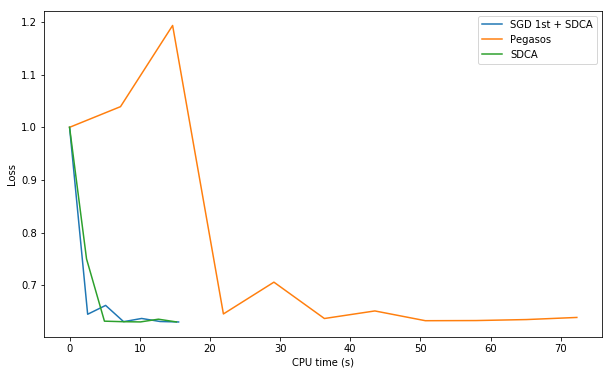

In [48]:
# Stack perfs and losses in tuples and plot loss as a functions of perfs
perfs_tuple = (perfs_sdca_sgd, perfs_pegasos, perfs_sdca)
losses_tuple = (losses_sdca_sgd, losses_pegasos, losses_sdca)
labels_tuple = ("SGD 1st + SDCA", "Pegasos", "SDCA")
plot_logloss_cputime(perfs_tuple, losses_tuple, labels_tuple)

In [50]:
def plot_testscore_epoch(scores_tuple, labels_tuple):
    """
    Plot test score as a function of number of elpased epoch 
    
    Params:
        scores_tuple (tuple) : tuple of list of scores tracking
        labels_tuple (tuple) : tuple of labels 
    
    Returns
        NoneType.
    """
    fig = plt.figure(figsize=(10, 6))
    for i in range(0, len(perfs_tuple)):
        plt.plot(scores_tuple[i], label = labels_tuple[i])
    plt.ylabel("Error rate on test set")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

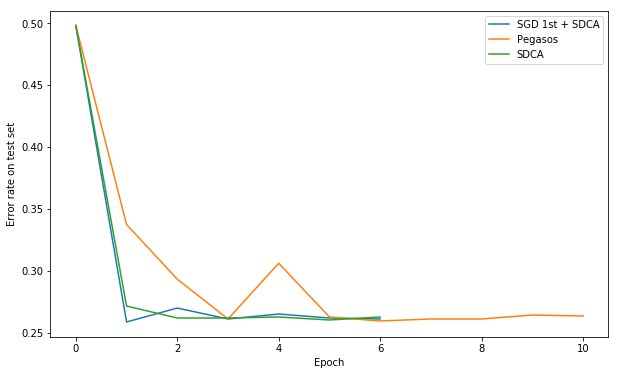

In [51]:
# Stack scores and plot
scores_tuple = (scores_sdca_sgd, scores_pegasos, scores_sdca)
plot_testscore_epoch(scores_tuple, labels_tuple)

In [52]:
# Print scores on test set for both algos
ypred_sdca = classify(w_sdca, xtest)
ypred_pegasos = classify(w_pegasos, xtest)
print("Score SDCA : " + str(metrics.zero_one_loss(ypred_sdca, ytest)))
print("Score Pegasos : " + str(metrics.zero_one_loss(ypred_pegasos, ytest)))

Score SDCA : 0.262861736334
Score Pegasos : 0.263665594855


In [56]:
def plot_duality_gaps(gaps_tuple, labels_tuple):
    """
    Plot evolultion of duality gaps as a function of elapsed epochs
    
    Params:
        gaps_tuple (tuple) : tuple of list of gaps tracking
        labels_tuple (tuple) : tuple of labels 
    
    Returns
        NoneType.
    """
    fig = plt.figure(figsize=(10, 6))
    for i in range(0, len(gaps_tuple)):
        plt.plot(gaps_tuple[i], label = labels_tuple[i])
    plt.ylabel("Duality gap")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

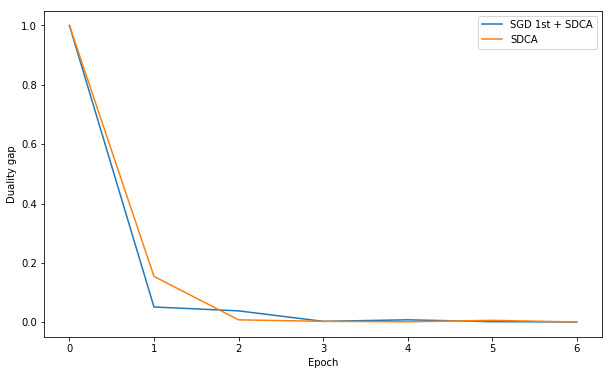

In [57]:
# Plots duality gaps
gaps_tuple = (gaps_sdca_sgd, gaps_sdca)
labels_sdca_tuple = ("SGD 1st + SDCA", "SDCA")
plot_duality_gaps(gaps_tuple, labels_sdca_tuple)

### A more robust comparison on raw images with Monte Carlo

In [60]:
# Perform several runs of SDCA and averages the losses, performances etc... over those runs
# WARNING : THIS TAKES QUITE A LONG TIME (APPROXIMATELY 35 MINS)

# Number of runs
nmc = 50

# Parameters for SDCA
lamb = 1.6
nepochs_sdca = 10

# We want to make sure that there will be not early stopping to average over lists of the same sizes
epsilon = -1

# Run sdca nmc times on raw images
start = time.clock()
losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = mc_comparisons_sdca(xtrain,
                                                                      ytrain,
                                                                      lamb,
                                                                      nepochs_sdca,
                                                                      xtest,
                                                                      ytest,
                                                                      nmc=nmc,
                                                                      epsilon=epsilon,
                                                                      sgd_first=False)
end = time.clock()
print(end - start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2112.101434


In [64]:
# Perform several runs of SDCA with SGD first and averages the losses, performances etc... over those runs
# WARNING : THIS TAKES QUITE A LONG TIME (APPROXIMATELY 35 MINS)

start = time.clock()
losses_sdca_sgd, perfs_sdca_sgd, gaps_sdca_sgd, scores_sdca_sgd = mc_comparisons_sdca(xtrain,
                                                                                      ytrain,
                                                                                      lamb,
                                                                                      nepochs_sdca, 
                                                                                      xtest,
                                                                                      ytest,
                                                                                      nmc=nmc,
                                                                                      epsilon=epsilon,
                                                                                      sgd_first=True)
end = time.clock()
print(end - start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2095.683736


In [62]:
# Perform several runs of Pegasos and averages the losses, performances etc... over those runs
# WARNING : THIS TAKES QUITE A LONG TIME (APPROXIMATELY 35 MINS)

# Number of runs
nmc = 50

# Set parameters for Pegasos 
lamb = 1.6
nepochs_pegasos = 10
minibatch_pegasos = 100

# Run Pegasos nmc times on raw images
losses_pegasos, perfs_pegasos, scores_pegasos = mc_comparisons_pegasos(xtrain, 
                                                                       ytrain, 
                                                                       lamb, 
                                                                       minibatch_pegasos, 
                                                                       nepochs_pegasos, 
                                                                       xtest, 
                                                                       ytest, 
                                                                       nmc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


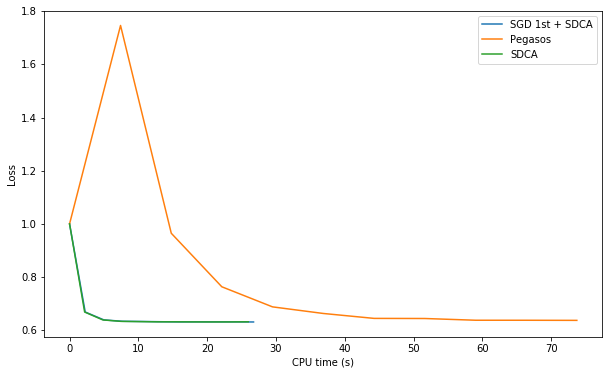

In [65]:
# Stack perfs and losses in tuples and plot loss as a functions of perfs
perfs_tuple = (perfs_sdca_sgd, perfs_pegasos, perfs_sdca)
losses_tuple = (losses_sdca_sgd, losses_pegasos, losses_sdca)
labels_tuple = ("SGD 1st + SDCA", "Pegasos", "SDCA")
plot_logloss_cputime(perfs_tuple, losses_tuple, labels_tuple)

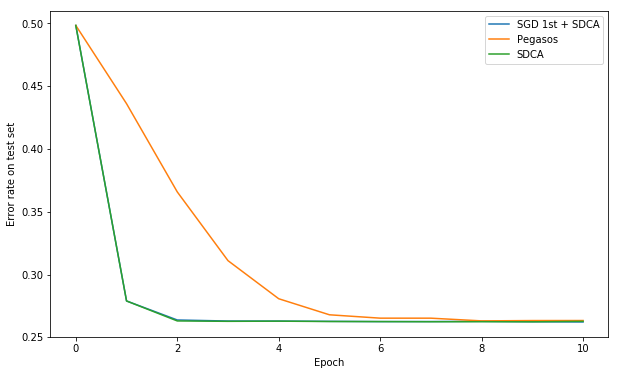

In [66]:
# Stack scores and plot
scores_tuple = (scores_sdca_sgd, scores_pegasos, scores_sdca)
plot_testscore_epoch(scores_tuple, labels_tuple)

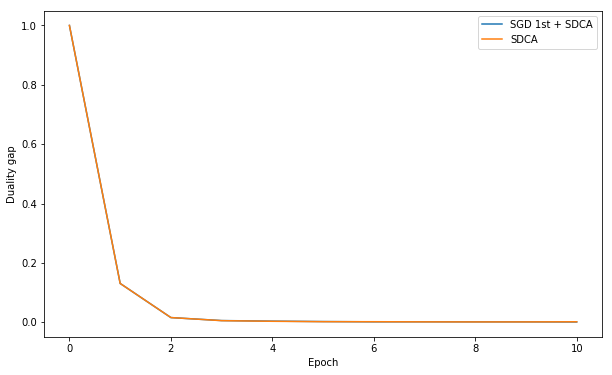

In [67]:
# Plots duality gaps
gaps_tuple = (gaps_sdca_sgd, gaps_sdca)
labels_sdca_tuple = ("SGD 1st + SDCA", "SDCA")
plot_duality_gaps(gaps_tuple, labels_sdca_tuple)

## PCA for dimension reduction

In [68]:
def compute_pca(xmat, ncomps):
    """
    Fit a PCA using the scikit learn library
    
    Params:
        xmat (numpy.ndarray) : the data matrix (images as columns)
        ncomps (int) : number of components to keep
    
    Returns:
        
    """
    pca = decomposition.PCA(n_components=ncomps, whiten=True, svd_solver="randomized").fit(xmat.T)
    return pca

In [69]:
def pca_dimension_reduction(pca, xmat):
    return pca.transform(xmat.T).T

In [70]:
# Reduce dimension using PCA

# Number of components to keep
ncomps = 40

# Compute PCA
pca_xtrain = compute_pca(xtrain, ncomps)

# Compute reduced data keeping only the ncomps first components
xtrain_reduced = pca_dimension_reduction(pca_xtrain, xtrain)

# We use the PCA COMPUTED ON XTRAIN to reduce the test set
xtest_reduced = pca_dimension_reduction(pca_xtrain, xtest)

# Project images on the span of the first ncomps components to see what they look like
components = pca_xtrain.components_.T
projected = np.dot(components, xtrain_reduced)

In [71]:
neutrophils_transformed = data_from_label(projected, ytrain, 1)
neutrophils = data_from_label(xtrain, ytrain, 1)
lymphocytes_transformed = data_from_label(projected, ytrain, -1)

Text(0.5,0.98,u'Neutrophils - Projection on the 40 first principal components')

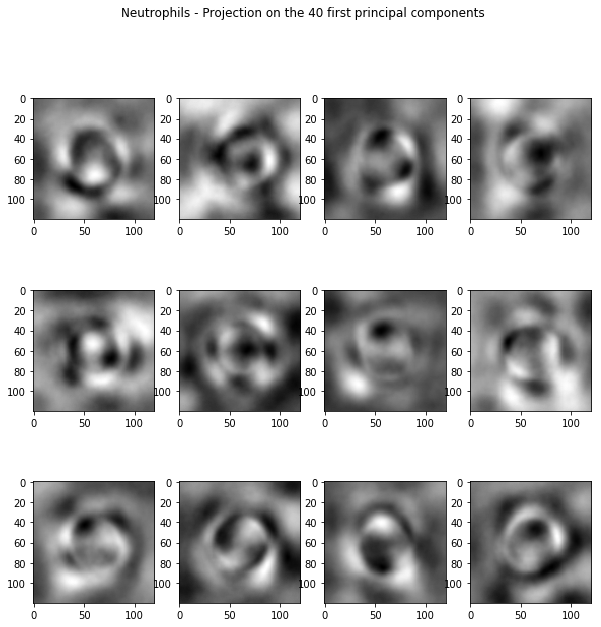

In [74]:
# Plot some examples of PCA transformed cropped neutrophils images
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(neutrophils_transformed[:, i + 4*j].reshape((120, 120)), "gray")
plt.suptitle("Neutrophils - Projection on the " + str(ncomps) + " first principal components")

Text(0.5,0.98,u'Lymphocytes - Projection on the 40 first principal components')

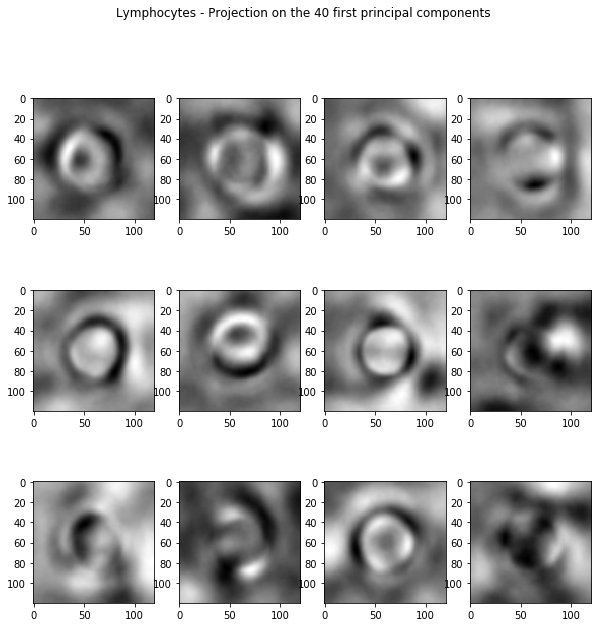

In [75]:
# Plot some examples of PCA transformed cropped lymphocytes images
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for i in range(0, 4):
    for j in range(0, 3):
        axes[j, i].imshow(lymphocytes_transformed[:, i + 4*j].reshape((120, 120)), "gray")
plt.suptitle("Lymphocytes - Projection on the " + str(ncomps) + " first principal components")

### Run SDCA and Pegasos on PCA reduced images

In [76]:
# Parameters for SDCA
lamb = 1.6
nepochs_sdca = 10
epsilon = 0.001
n = xtrain_reduced.shape[1] 
alpha0 = np.zeros((n, ))

# Run SDCA without modified SGD as first epoch
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                                xtrain_reduced, 
                                                                                ytrain, 
                                                                                lamb, 
                                                                                nepochs_sdca, 
                                                                                epsilon, 
                                                                                sgd_first=False, 
                                                                                xtest=xtest_reduced, 
                                                                                ytest=ytest)
# Print how long it took
print(np.sum(perfs_sdca))

# Run SDCA with modified SGD as first epoch
w_sdca_sgd, alpha_sdca_sgd, losses_sdca_sgd, perfs_sdca_sgd, gaps_sdca_sgd, scores_sdca_sgd = sdca_perm(
    alpha0, 
    xtrain_reduced, 
    ytrain, lamb, 
    nepochs_sdca, 
    epsilon, 
    sgd_first=False, 
    xtest=xtest_reduced, 
    ytest=ytest)
# Print how long it took
print(np.sum(perfs_sdca_sgd))

1.45197
1.546377


In [77]:
# Set parameters for Pegasos 
lamb = 1.6
d = xtrain_reduced.shape[0]
w_pegasos = np.zeros((d, ))
nepochs_pegasos = 10
minibatch_pegasos = 100

# Run Pegasos
losses_pegasos, perfs_pegasos, scores_pegasos = pegasos_algorithm(w_pegasos, 
                                                                  xtrain_reduced, 
                                                                  ytrain, 
                                                                  lamb, 
                                                                  minibatch_pegasos, 
                                                                  nepochs_pegasos, 
                                                                  xtest=xtest_reduced, 
                                                                  ytest=ytest)
print(np.sum(perfs_pegasos))

0.142141000002


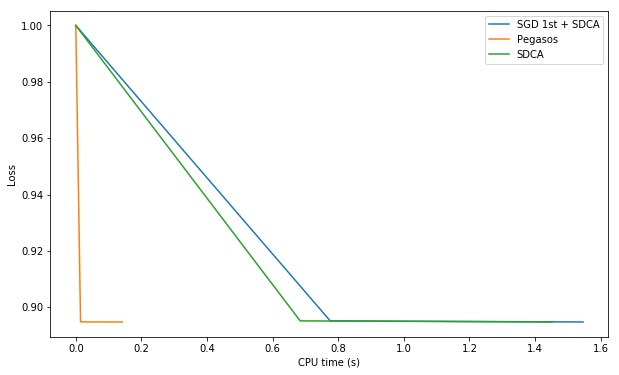

In [78]:
# Stack perfs and losses in tuples and plot loss as a functions of perfs
perfs_tuple = (perfs_sdca_sgd, perfs_pegasos, perfs_sdca)
losses_tuple = (losses_sdca_sgd, losses_pegasos, losses_sdca)
labels_tuple = ("SGD 1st + SDCA", "Pegasos", "SDCA")
plot_logloss_cputime(perfs_tuple, losses_tuple, labels_tuple)

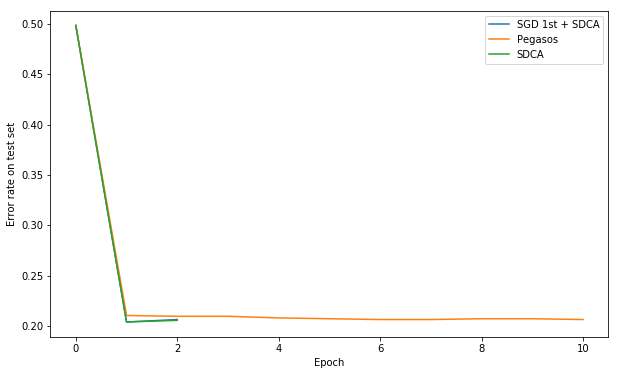

In [81]:
# Stack scores and plot
scores_tuple = (scores_sdca_sgd, scores_pegasos, scores_sdca)
plot_testscore_epoch(scores_tuple, labels_tuple)

In [80]:
# Print scores on test set for both algos
ypred_sdca = classify(w_sdca, xtest_reduced)
ypred_pegasos = classify(w_pegasos, xtest_reduced)
print("Score SDCA : " + str(metrics.zero_one_loss(ypred_sdca, ytest)))
print("Score Pegasos : " + str(metrics.zero_one_loss(ypred_pegasos, ytest)))

Score SDCA : 0.20578778135
Score Pegasos : 0.206591639871


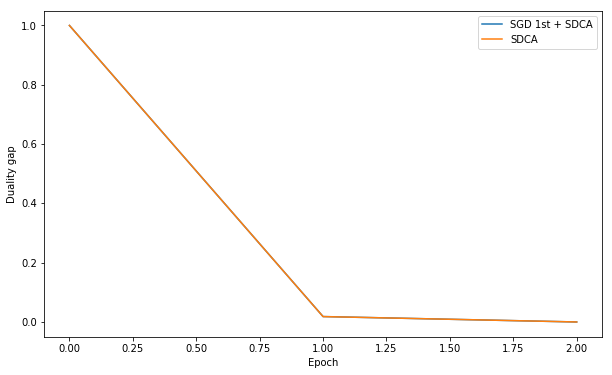

In [82]:
# Plots duality gaps
gaps_tuple = (gaps_sdca_sgd, gaps_sdca)
labels_sdca_tuple = ("SGD 1st + SDCA", "SDCA")
plot_duality_gaps(gaps_tuple, labels_sdca_tuple)

### Monte carlo averaging of algorithms runs on PCA reduced data

In [83]:
# Perform several runs of SDCA and averages the losses, performances etc... over those runs

# Number of runs
nmc = 50

# Parameters for SDCA
lamb = 1.6
nepochs_sdca = 10

# We want to make sure that there will be not early stopping to average over lists of the same sizes
epsilon = -1

# Run sdca nmc times on raw images
start = time.clock()
losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = mc_comparisons_sdca(xtrain_reduced,
                                                                      ytrain,
                                                                      lamb,
                                                                      nepochs_sdca,
                                                                      xtest_reduced,
                                                                      ytest,
                                                                      nmc=nmc,
                                                                      epsilon=epsilon,
                                                                      sgd_first=False)
end = time.clock()
print(end - start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
383.465751


In [84]:
# Perform several runs of SDCA with SGD first and averages the losses, performances etc... over those runs

start = time.clock()
losses_sdca_sgd, perfs_sdca_sgd, gaps_sdca_sgd, scores_sdca_sgd = mc_comparisons_sdca(xtrain_reduced,
                                                                                      ytrain,
                                                                                      lamb,
                                                                                      nepochs_sdca, 
                                                                                      xtest_reduced,
                                                                                      ytest,
                                                                                      nmc=nmc,
                                                                                      epsilon=epsilon,
                                                                                      sgd_first=True)
end = time.clock()
print(end - start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
380.767721


In [85]:
# Perform several runs of Pegasos and averages the losses, performances etc... over those runs

# Number of runs
nmc = 50

# Set parameters for Pegasos 
lamb = 1.6
nepochs_pegasos = 10
minibatch_pegasos = 100

# Run Pegasos nmc times on raw images
losses_pegasos, perfs_pegasos, scores_pegasos = mc_comparisons_pegasos(xtrain_reduced, 
                                                                       ytrain, 
                                                                       lamb, 
                                                                       minibatch_pegasos, 
                                                                       nepochs_pegasos, 
                                                                       xtest_reduced, 
                                                                       ytest, 
                                                                       nmc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


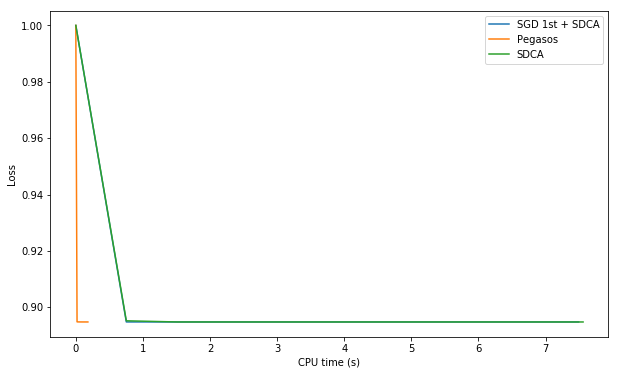

In [86]:
# Stack perfs and losses in tuples and plot loss as a functions of perfs
perfs_tuple = (perfs_sdca_sgd, perfs_pegasos, perfs_sdca)
losses_tuple = (losses_sdca_sgd, losses_pegasos, losses_sdca)
labels_tuple = ("SGD 1st + SDCA", "Pegasos", "SDCA")
plot_logloss_cputime(perfs_tuple, losses_tuple, labels_tuple)

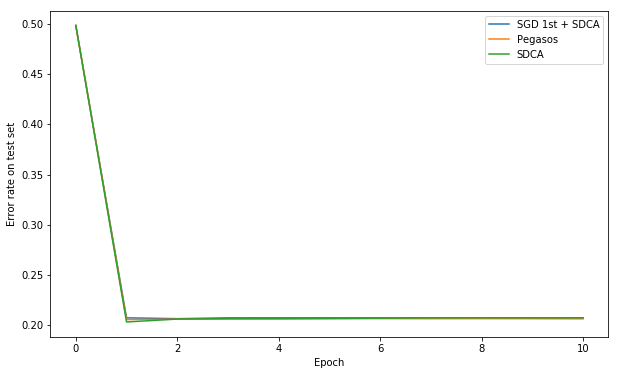

In [88]:
# Stack scores and plot
scores_tuple = (scores_sdca_sgd, scores_pegasos, scores_sdca)
plot_testscore_epoch(scores_tuple, labels_tuple)

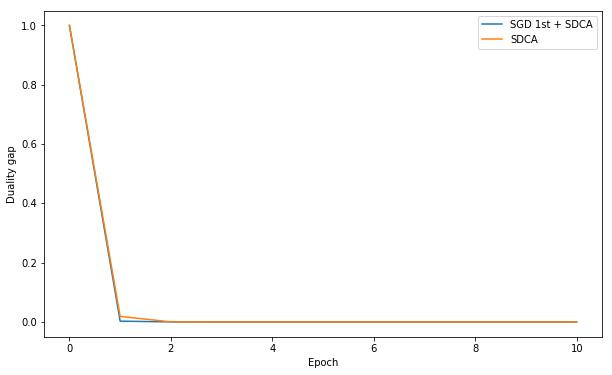

In [89]:
# Plots duality gaps
gaps_tuple = (gaps_sdca_sgd, gaps_sdca)
labels_sdca_tuple = ("SGD 1st + SDCA", "SDCA")
plot_duality_gaps(gaps_tuple, labels_sdca_tuple)